## Machine Learning applied to identify low hemolytic Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the hemolysis model.

In [4]:
import os
import torch
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [5]:
# Load meta data
meta_data = pd.read_excel("data/Cumulative_Peptide_data_PG1_v01.2.xlsx", usecols=['ID', 'Sequence', '%Hemolysis'])
meta_data

,ID,Sequence,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,15.821069
...,...,...,...
88,PG-1.32,HGWRLCYCRRRFCVCVGC,35.460367
89,PG-1.60,RGGRLCYCRRRFCVCVGF,36.664085
90,PG-1.25,RGWRLCYCRRRFCVCVGH,46.397292
91,PG-1.7,RRWCLCFCRRRFCVCVCR,51.181276


## Embedding Extraction

The embeddings I used for the model were computed using the ESM-2 15B model and I used the mean of the last layer as the embedding.

Here's how to exytract them using the pre-trained model from esm2.  

Download the python file extract from [esm2-github](https://github.com/facebookresearch/esm), and make sure to have a conda enviromment seted up accordinly.

Then run:  
python extract.py esm2_t48_15B_UR50D data/Cumulative_Peptide_data_PG1.fasta data/embedding/esm2_15B_PG1 --repr_layers 48 --include mean

In [6]:
# creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
data

,ID,Sequence,%Hemolysis,0,1,2,3,4,5,6,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,2.600000,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1.607281,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,3.233927,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,12.103021,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,15.821069,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,PG-1.32,HGWRLCYCRRRFCVCVGC,35.460367,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,-0.117476,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
89,PG-1.60,RGGRLCYCRRRFCVCVGF,36.664085,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,-0.079077,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
90,PG-1.25,RGWRLCYCRRRFCVCVGH,46.397292,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,-0.080665,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
91,PG-1.7,RRWCLCFCRRRFCVCVCR,51.181276,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,-0.059348,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


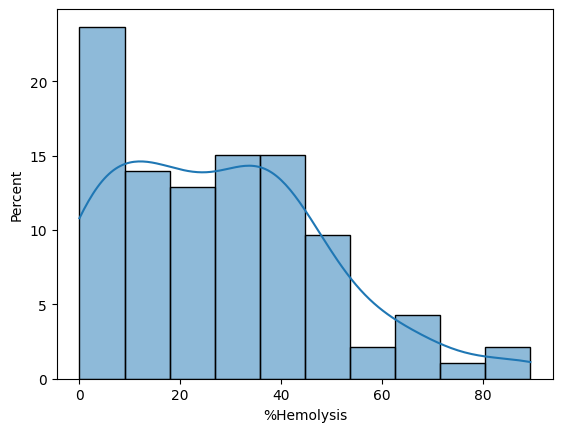

In [7]:
# plot target distribution
sns.histplot(data=data, x='%Hemolysis', bins=10, kde=True, stat='percent')
plt.show()

In [8]:
# Define target and features
data["%Hemolysis"] = data["%Hemolysis"].round(2)
target = data["%Hemolysis"]

# define features
features = data.iloc[:, meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471


## Split data into train and test sets

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### PCAs before feature selection

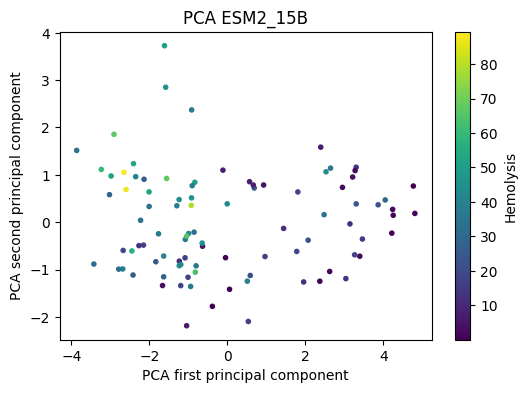

In [10]:
num_pca_components = 2
pca = PCA(num_pca_components)
X_train_pca = pca.fit_transform(features)
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=target, marker='.')
plt.title(f'PCA ESM2_15B')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Hemolysis')
plt.show()

### Selecting features by correlation

In [11]:
def get_correlated_columns(df, target, threshold):
    # correlating train target  with train set
    corr_matrix = df.corrwith(target).abs().sort_values()

    # create a list of columns with high positive or negative correlation
    correlated_columns = []
    for column in corr_matrix.index:
        if (corr_matrix[column] >= threshold) & (column not in correlated_columns):
            correlated_columns.append(column)

    return(correlated_columns)

corr_columns = get_correlated_columns(X_train, y_train, 0.6)
len(corr_columns)

115

In [12]:
# selecting features
XX_train = X_train[corr_columns]
XX_test = X_test[corr_columns]

### PCAs after feature selection 

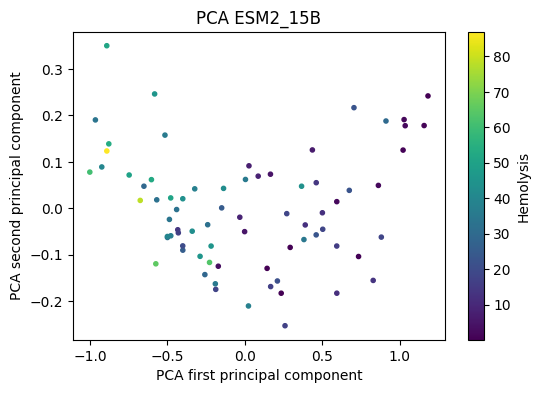

In [10]:
num_pca_components = 2
pca = PCA(num_pca_components)
X_train_pca = pca.fit_transform(XX_train)
fig_dims = (6, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train, marker='.')
plt.title(f'PCA ESM2_15B')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Hemolysis')
plt.show()

## Running Regression Models for testing code

In [11]:
# store the results
results = pd.DataFrame()
results_cv = pd.DataFrame()

# Create a list of models to test
#models = [Lasso(), SVR(), RandomForestRegressor()]
models = [Lasso(), SVR()]

# Create a dictionary of hyperparameters for each model
param_grid = [
    # Lasso
    {'alpha': np.arange(0.01, 1, 0.01),'max_iter': [10000, 100000]},
    # SVR
    {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
    'gamma': ['scale', 0.1, 0.01, 0.001, 0.0001]},
    ## RandomForestRegressor
    #{'n_estimators': [100, 200, 300, 500, 700], 'max_depth': [None, 2, 3, 4, 5, 10]}, 
    ]

    # train scores
# Iterate over the models and fit and predict using grid search
for model, param_grid in zip(models, param_grid):
    
    # search best hyperparameter 
    grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=10, n_jobs=10)
    
    # k-fold cross-validation on the training set
    r2_cv_scores = cross_val_score(grid_search, XX_train, y_train, cv=10, scoring='r2', n_jobs=10)
    mae_cv_scores = cross_val_score(grid_search, XX_train, y_train, cv=10, scoring='neg_mean_absolute_error', n_jobs=10)

    # train in the whole training set
    grid_search.fit(XX_train, y_train)

    # make predictions
    train_pred = grid_search.predict(XX_train)
    test_y_pred = grid_search.predict(XX_test)
    
    # Model evaluation on test data
    train_r2 = r2_score(y_train, train_pred)
    train_mae = mean_absolute_error(y_train, train_pred)
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)

    # Model evaluation on test data
    test_r2 = r2_score(y_test, test_y_pred)
    test_mae = mean_absolute_error(y_test, test_y_pred)
    test_mse = mean_squared_error(y_test, test_y_pred)
    test_rmse = np.sqrt(test_mse)

    model_name = grid_search.best_estimator_.__class__.__name__
    embed_name = dir_path.split('/')[-2]
    best_params = str(grid_search.best_params_)
    
    # print best scores
    print(f"Model: {model_name}, Train R2:{train_r2:.2f}, Test R2:{test_r2:.2f}, best params {best_params}")
    print("R2 CV Scores:", r2_cv_scores)
    print()

    # Saving results
    res_dict = {}
    res_dict["Embedding"] = embed_name
    res_dict["model"] = model_name
    res_dict["Train_R2_score"] = train_r2.round(2)
    res_dict["Train_MAE_score"] = train_mae.round(2)
    res_dict["Train_RMSE_score"] = train_rmse.round(2)

    # test scores
    res_dict["Test_R2_score"] = test_r2.round(2)
    res_dict["Test_MAE_score"] = test_mae.round(2)
    res_dict["Test_RMSE_score"] = test_rmse.round(2)
    res_dict["Test_Best_params"] = best_params
    
    # updating data frame with results
    results = pd.concat([results, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)

    # save results from cross-validation
    res_cv_dict = {
        "model": [model_name for i in range(10)],
        "R2_CV_scores": r2_cv_scores,
        "Mae_CV_scores": mae_cv_scores,
    }
    # updating data frame with results
    results_cv = pd.concat([results_cv, pd.DataFrame(res_cv_dict)]).reset_index(drop=True)

#results.to_excel('results/results_regression_hemolysis_v01.xlsx')
#results_cv.to_excel('results/results_cv_regression_hemolysis_v01.xlsx')

Model: Lasso, Train R2:0.77, Test R2:0.73, best params {'alpha': 0.03, 'max_iter': 10000}
R2 CV Scores: [0.2272147  0.82221172 0.30062215 0.744938   0.47289064 0.56639901
 0.62593993 0.76854613 0.27646877 0.89952465]

Model: SVR, Train R2:0.75, Test R2:0.73, best params {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
R2 CV Scores: [0.30424542 0.68582209 0.19833875 0.35682633 0.32414268 0.49690145
 0.68257869 0.60070241 0.396763   0.51689326]



## Results Visualization

In [18]:
#results_cv = pd.read_excel('results/results_cv_regression_hemolysis_new.xlsx', index_col=0)
results_cv.groupby('model').mean()

,R2_CV_scores,Mae_CV_scores
model,,
Lasso,0.570476,-9.176693
SVR,0.456321,-10.927249


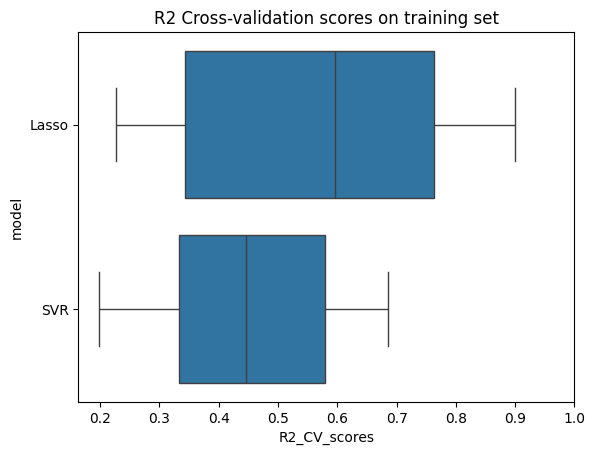

In [19]:
sns.boxplot(data=results_cv, y='model', x='R2_CV_scores',showfliers=False)
plt.title('R2 Cross-validation scores on training set')
plt.xlim(right=1)
plt.show()

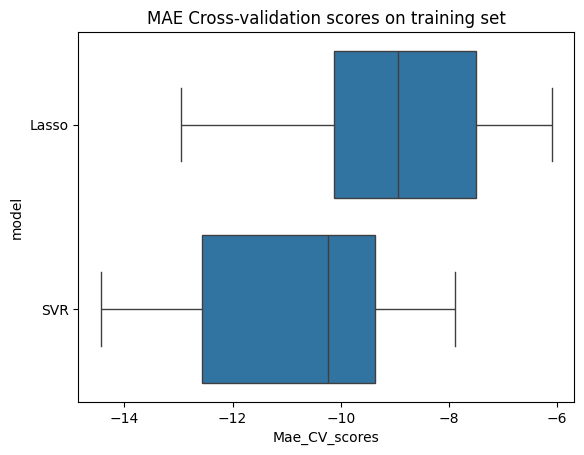

In [20]:
sns.boxplot(data=results_cv, y='model', x='Mae_CV_scores',showfliers=False)
plt.title('MAE Cross-validation scores on training set')
plt.show()

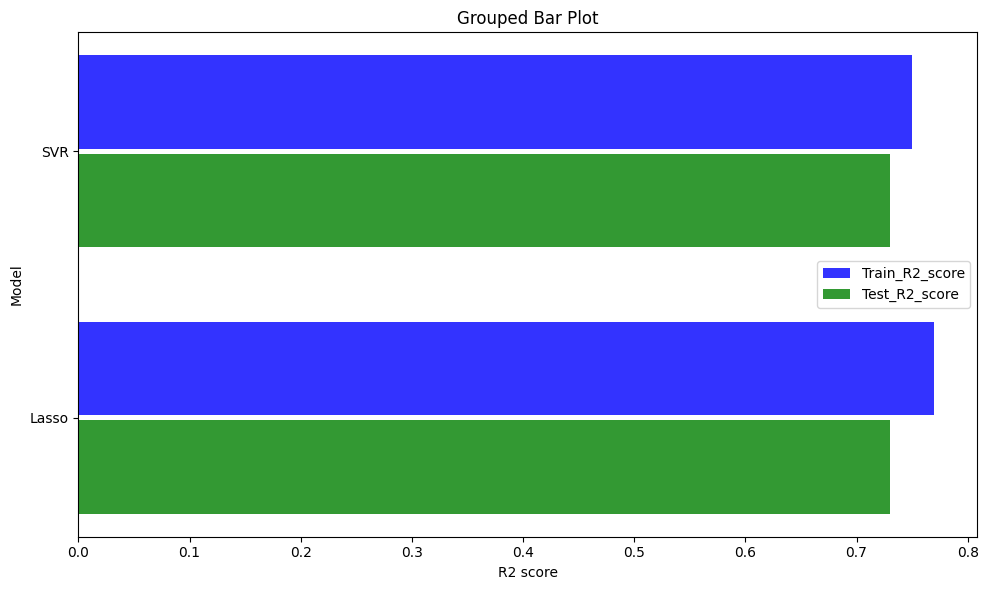

In [22]:
# Replace 'column1' and 'column2' with the names of the columns you want to plot
column1 = 'Train_R2_score'
column2 = 'Test_R2_score'

# Create a bar plot with two bars per group
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(results))
bar_height = 0.35
opacity = 0.8

# +/- 0.01 is to create a small space between bars
rects1 = ax.barh(y + bar_height/2 + 0.01, results[column1], bar_height, 
                 alpha=opacity, color='b', label=column1)
rects2 = ax.barh(y - bar_height/2 - 0.01, results[column2], bar_height,
                 alpha=opacity, color='g', label=column2)


# Add labels and legend
ax.set_ylabel('Model')
ax.set_xlabel('R2 score')
ax.set_title('Grouped Bar Plot')
ax.set_yticks(y)
ax.set_yticklabels(results['model'])
ax.legend()
plt.tight_layout()
plt.show()


To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation.   
If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting.   
In such cases, it may be necessary to adjust the hyperparameters of the model or to use a less complex kernel function.


**Train R-squared (R2: ~0.7):**  
This is a measure of how well the SVR model fits the training data. An R2 score of 0.75 indicates that your model explainsapproximately 75% of the variability in the training data. This is a reasonably good fit, suggesting that the model has learned some of the underlying patterns in the training data.

**Test R-squared (R2: ~0.7):**  
The R2 score on the test data is also high (0.72), which is a positive sign. It suggests that the model's performance is consistent between the training and test datasets, which indicates that the model is generalizing well to unseen data.
 

**R2 and MAE CV Scores:**    
A consistent cross-validation (CV) scores indicates that the model performs well on different subsets of the data.
The range of our model's CV scores suggests that your model's performance can vary slightly depending on the data split due the small size of the data, but the overall trend is positive.

In summary, the Lasso model with a apha=0.04 appears to be performing well and avoiding overfitting. The train and test R2 scores are close, indicating good generalization.

## Fine Tunning Model with best hyperparameter found with Gridsearch

### Lasso

In [ ]:
results.iloc[0, 8]

In [13]:
lasso = Lasso(
    alpha=0.03,
    max_iter=10000    
)

# fined tuned model performance
lasso.fit(XX_train, y_train)


# print R2 score
print(f'Train R2 score: {lasso.score(XX_train, y_train):.2f}')
print(f'Test R2 score: {lasso.score(XX_test, y_test):.2f}')

Train R2 score: 0.77
Test R2 score: 0.73


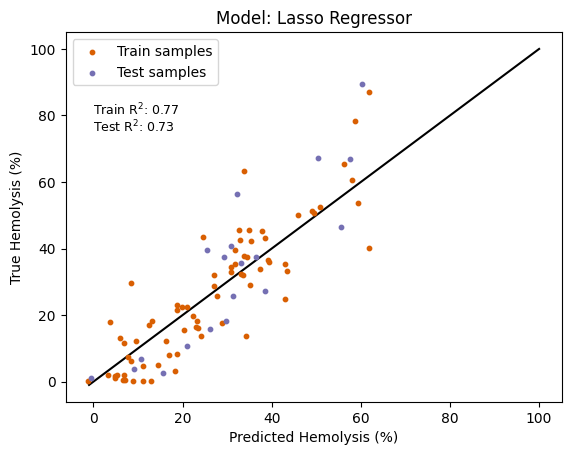

In [19]:

train_pred = lasso.predict(XX_train)
y_pred = lasso.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02', s=10)
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3', s=10)
plt.title(f"Model: Lasso Regressor")
plt.xlabel("Predicted Hemolysis (%)")
plt.ylabel("True Hemolysis (%)")
plt.plot([-1, 100], [-1, 100], c='k', zorder=0) 
plt.text(0, 80, f'Train R$^2$: {lasso.score(XX_train, y_train).round(2)}', fontsize = 9)
plt.text(0, 75, f'Test R$^2$: {lasso.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.savefig('results/lasso_regression_hemolysis.png', dpi=600)
plt.show()

### SVR

In [26]:
results.iloc[1, 8]

"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}"

In [27]:
# train support vector machine regressor
svr = SVR(
    C=100, 
    gamma='scale',
    kernel='rbf',
    )

# fined tuned SVR performance
svr.fit(XX_train, y_train)

# print R2 score
print(f'Train R2 score: {svr.score(XX_train, y_train):.2f}')
print(f'Test R2 score: {svr.score(XX_test, y_test):.2f}')

Train R2 score: 0.75
Test R2 score: 0.73


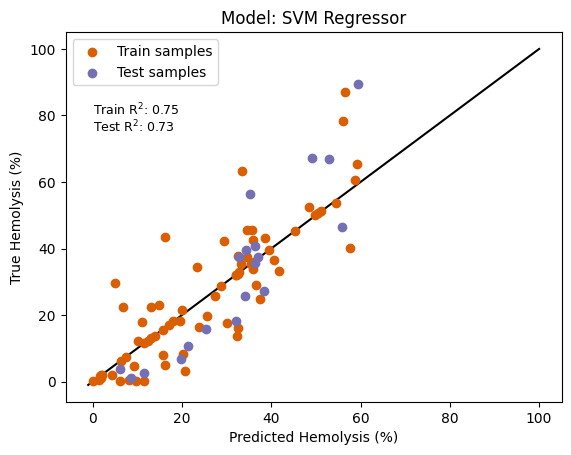

In [28]:
train_pred = svr.predict(XX_train)
y_pred = svr.predict(XX_test)

plt.scatter(train_pred, y_train, label="Train samples", c='#d95f02')
plt.scatter(y_pred, y_test, label="Test samples", c='#7570b3')
plt.title(f"Model: SVM Regressor")
plt.xlabel("Predicted Hemolysis (%)")
plt.ylabel("True Hemolysis (%)")
plt.plot([-1, 100], [-1, 100], c='k', zorder=0) 
plt.text(0, 80, f'Train R$^2$: {svr.score(XX_train, y_train).round(2)}', fontsize = 9)
plt.text(0, 75, f'Test R$^2$: {svr.score(XX_test, y_test).round(2)}', fontsize = 9)
plt.legend()
plt.show()

# Save the lasso madel and the correlated columns

In [ ]:
model = lasso

In [14]:
import joblib

joblib.dump(lasso, 'models/model_v01.2_Lasso_esm2_15B_Hemolysis_regression_corr06.pkl')

# save the list to a file
with open('models/correlated_columns_v01.2_esm2_15B_hemolysis_corr06.pkl', 'wb') as f:
    pickle.dump(corr_columns, f)